In [74]:
# ! pip install numpy matplotlib

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from enum import Enum
from collections import defaultdict
from abc import ABC, abstractmethod

# Set grid world generic enveorment

### background
this is a generic env that can be also determenistic and stochastic, depend on the parameter "is_stochastic" in the constractor

The environment is by default a 5×5 GridWorld with deterministic and stochastic modes.
The agent starts position, goal position, trussures and traps position are given in the constractor.
By default rap cells give a penalty of -1, and standard steps give -0.01.
In stochastic mode, actions may randomly shift to neighboring directions with a small probability.

### class description
The env class get the foloing parameters:
1) width - the with of the grid
2) height - the height of the grid
3) startPos - the start position of the agent
4) goal_pos - the position of the goal cell
5) is_stochastic - set the grid actions type
6) treasures - list of position of treasures
7) traps - list of positions of traps 
8) treasures_value = the reward that treasuress gives
9) traps_value - the reward traps gives
10) empty_cell_values - the reward of empty cell

### functions:
`Step(action)` - get action enum and return the new state and info message

`render()` - render mathplotlib image of the gridworld, this function has optional parameters to set the color of each cell type

`get_action_space()` - return list of all available actions (left,right,up,down)

`get_states_space()` - return list of every available state, each state will present by tuple of (X,Y)

### Env visualization
The rendered image displays the GridWorld environment used in the project. Each cell in the grid represents a possible state that the agent can occupy. The visualization includes several color-coded elements to help interpret the structure and behavior of the environment:

**Blue Cell:** Indicates the current position of the agent. This cell changes as the agent moves during an episode.

**Green Cell:** Represents the goal state. When the agent reaches this cell, the episode terminates and a positive reward is given.

**Brown Cells:** Represent trap states. These are valid states that the agent can move into, but they result in a negative reward and are intended to be avoided during training.

**White Cells**: Regular states where the agent can move freely. These typically provide a small step penalty to encourage efficient paths.

In [76]:
class Action(Enum):
    DOWN = (1,0)
    UP = (-1,0)
    LEFT = (0,-1)
    RIGHT = (0,1)

In [77]:
class TreasureHuntEnv:
    def __init__(self,width,height,start_pos,goal_pos,treasures,traps,is_stochastic,treasure_value,trap_value,empty_cell_value,goal_value):
        self.width = width
        self.height = height

        self.start_pos = start_pos
        self.goal_pos = goal_pos
        self.agent_pos = self.start_pos

        self.treasures = treasures[:]
        self.traps = traps[:]

        self.original_trussures = treasures[:]
        self.original_traps = traps[:]

        self.is_stochastic = is_stochastic

        self.treasure_value = treasure_value
        self.trap_value = trap_value
        self.empty_cell_value = empty_cell_value
        self.goaL_value = goal_value

    def step(self,action):
        info = ''
        actual_action = None
        reward = None 
        done = False

        if(not self.is_stochastic):
            actual_action = action
        else:
            #TODO fill stochastic movment
            pass

        new_x = max(0, min(self.width - 1, self.agent_pos[0] + actual_action.value[0]))
        new_y = max(0, min(self.height - 1, self.agent_pos[1] + actual_action.value[1]))

        last_agent_pos = (self.agent_pos[0],self.agent_pos[1])
        self.agent_pos = (new_x,new_y)

        #check if the agent move.
        #if not, it mean the agent try to step out of the grif
        if(not last_agent_pos == self.agent_pos):
            if(self.agent_pos in self.treasures):
                info = 'Agent find a treasures!'
                reward = self.treasure_value
                self.treasures.remove(self.agent_pos)

            elif(self.agent_pos in self.traps):
                info = 'Agent fall into a trap!'
                reward = self.trap_value
            else:
                info = 'Agent walk into empty cell'
                reward = self.empty_cell_value

            if(self.agent_pos == self.goal_pos):
                info = 'Agent get to the goal!'
                reward = self.goaL_value
                done = True
        else:
            info = 'Agent try ro step out of grid\'s bounds'
            reward = -10

        return self.agent_pos,reward,done, info
    

    def reset(self):
        info = 'Agent returned to start position'
        self.agent_pos = self.start_pos
        self.treasures = self.original_trussures[:]
        self.traps = self.original_traps[:]
        return self.agent_pos,info

    def render(self,
    return_fig = False,
        start_color = 'red',
        goal_color = 'green',
        agent_color = 'blue',
        treasure_color = '#c1f80a',
        trap_color = 'brown'):

        fig, ax = plt.subplots(figsize=(self.width, self.height))

        for x in range(self.width + 1):
            ax.axvline(x, color='gray', linewidth=1)
        for y in range(self.height + 1):
            ax.axhline(y, color='gray', linewidth=1)

        # Fill goal position
        if(self.agent_pos != self.goal_pos):
            ax.add_patch(plt.Rectangle(
                (self.goal_pos[1], self.height - self.goal_pos[0] - 1), 1, 1,
                facecolor=goal_color, label='Goal'
            ))

        # # Fill start position
        # if(self.agent_pos != self.start_pos):
        #     ax.add_patch(plt.Rectangle(
        #         (self.start_pos[1], self.height - self.start_pos[0] - 1), 1, 1,
        #         facecolor=start_color, label='start'
        #     ))

        # Fill trussures positions
        for treasure in self.treasures:
            if(treasure != self.agent_pos):
                ax.add_patch(plt.Rectangle(
                    (treasure[1], self.height - treasure[0] - 1), 1, 1,
                    facecolor=treasure_color, label='treasure'
                ))

        for trap in self.traps:
            if(trap != self.agent_pos):
                ax.add_patch(plt.Rectangle(
                    (trap[1], self.height - trap[0] - 1), 1, 1,
                    facecolor=trap_color, label='trap'
                ))
        
        # Fill agent position
        ax.add_patch(plt.Rectangle(
            (self.agent_pos[1], self.height - self.agent_pos[0] - 1), 1, 1,
            facecolor=agent_color, label='Agent'
        ))
        # Formatting
        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title("GridWorld Environment")

        if return_fig:
            return fig
        
        plt.show()
        plt.close(fig)

    def get_state_space(self):
        return [(i, j) for i in range(self.height) for j in range(self.width)]
    
    def get_action_space(self):
        return [
            Action.UP,
            Action.DOWN,
            Action.LEFT,
            Action.RIGHT
        ]


# Set hepers function for visualizations

In [78]:
def display_multiple_renders(figs, cols=5, cell_size=3):
    cols = min(cols, len(figs))
    rows = (len(figs) + cols - 1) // cols
    figsize = (cols * cell_size, rows * cell_size)  # Each cell is cell_size x cell_size inches

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.array(axes).reshape(-1)  # Make sure it's flat

    for i, f in enumerate(figs):
        canvas = FigureCanvas(f)
        canvas.draw()
        image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(canvas.get_width_height()[::-1] + (4,))
        axes[i].imshow(image)
        axes[i].axis('off')
        plt.close(f)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# Test the enviorment

First I will set initial env and run some manual steps and render function to see if the env class run properly

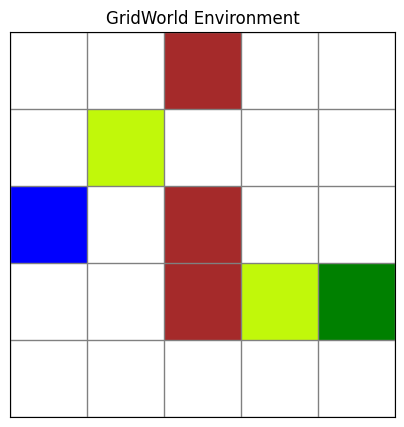

In [79]:
env = TreasureHuntEnv(5,5,(2,0),(3,4),[(3,3),(1,1),],[(2,2),(0,2),(3,2)],False,1,-1,-0.01,0)
env.render()

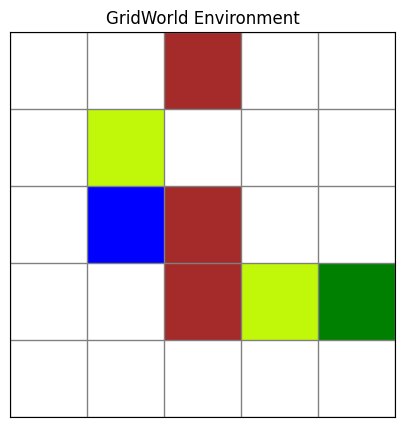

In [80]:
env.step(Action.RIGHT)
env.render()

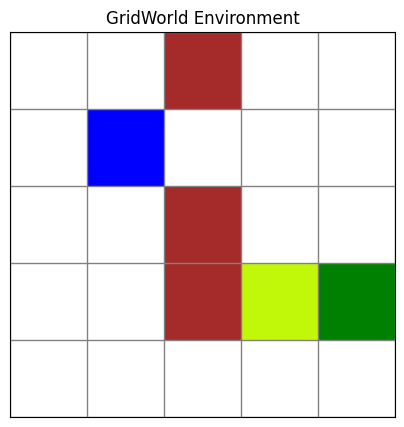

In [81]:
env.step(Action.UP)
env.render()

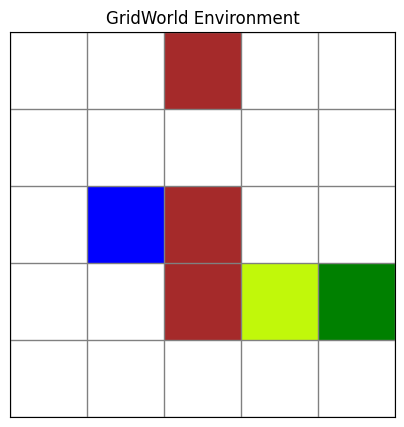

In [82]:
env.step(Action.DOWN)
env.render()

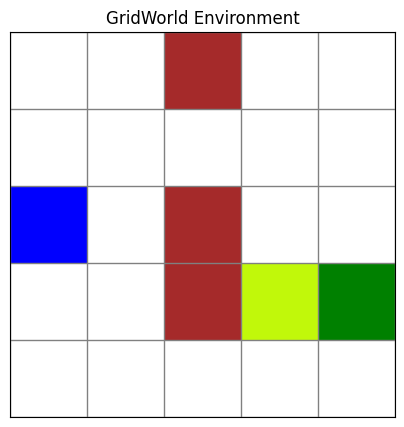

In [83]:
env.step(Action.LEFT)
env.render()

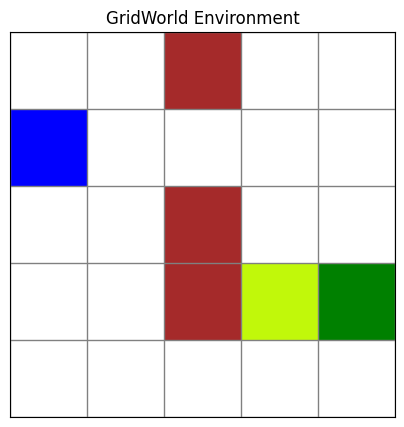

In [84]:
env.step(Action.UP)
env.render()

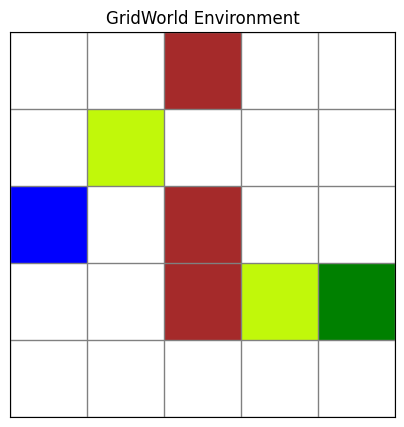

In [85]:
env.reset()
env.render()

## Try to print severals moves at once

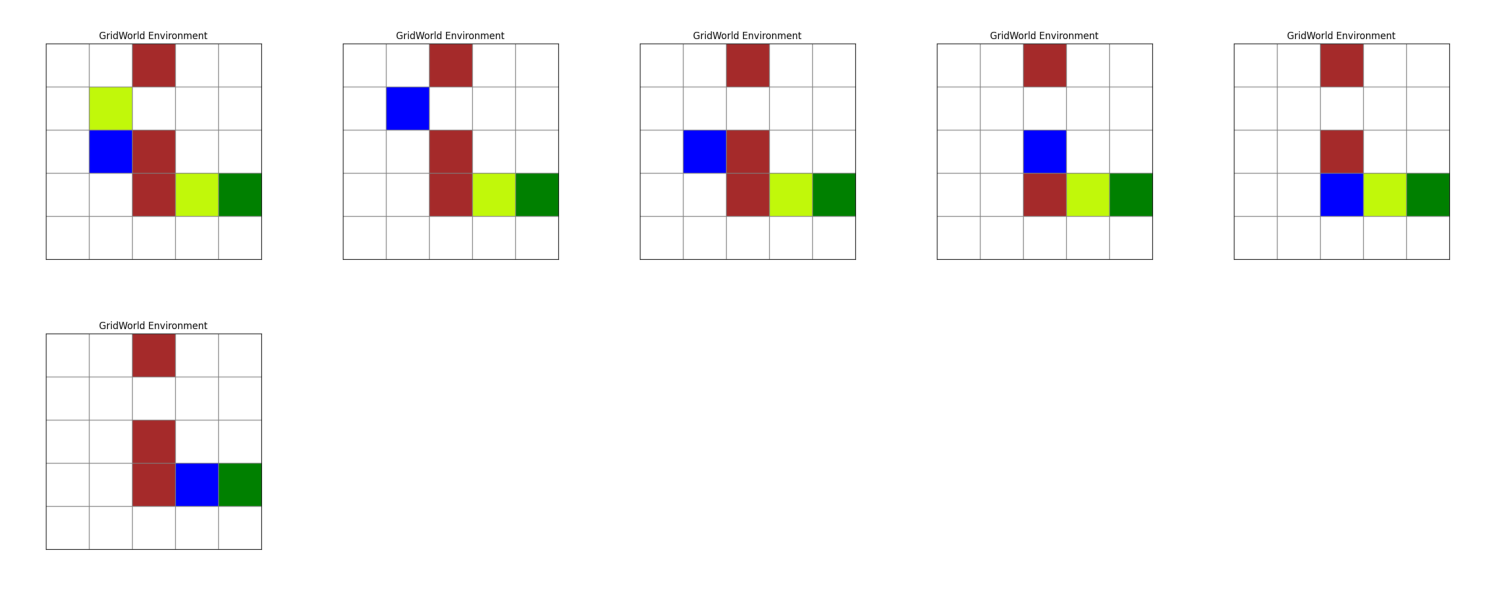

In [86]:
renders = []

env.step(Action.RIGHT)
renders.append(env.render(return_fig=True))
env.step(Action.UP)
renders.append(env.render(return_fig=True))
env.step(Action.DOWN)
renders.append(env.render(return_fig=True))
env.step(Action.RIGHT)
renders.append(env.render(return_fig=True))
env.step(Action.DOWN)
renders.append(env.render(return_fig=True))
env.step(Action.RIGHT)
renders.append(env.render(return_fig=True))


display_multiple_renders(renders)

## Model Training

In this section, we train the agent using two different reinforcement learning approaches:
**Monte Carlo Control** and **SARSA (State-Action-Reward-State-Action)**.

Both methods aim to learn an optimal policy for navigating the GridWorld environment by estimating the action-value function Q(s, a). While Monte Carlo relies on complete episodes and averaging returns, SARSA uses a step-by-step temporal-difference update that incorporates bootstrapping.

Below, we implement and run each method, observe the learning progress, and visualize the resulting policy to understand how the agent behaves after training.


### Base Class: `RL_Model`

To avoid code duplication and promote clean design, I defined an abstract base class `RL_Model` which encapsulates the core components common to both Monte Carlo and TD-based models (such as SARSA).

This class serves as a blueprint for any reinforcement learning agent that interacts with the `TreasureHuntEnv` environment. It includes:

- **Shared Hyperparameters**:  
  - `alpha`: learning rate  
  - `gamma`: discount factor  
  - `epsilon`: exploration rate (used in ε-greedy policy)

- **Policy Representation**:  
  The policy is stored as a dictionary mapping each state to a list of action probabilities (ε-soft). It is initialized to a uniform distribution over actions.

- **Action-Value Table `q`**:  
  A `defaultdict(float)` is used to store Q-values for each `(state, action)` pair.

- **Common Methods**:
  - `select_action(state)`: samples an action from the current ε-soft policy for the given state.
  - `exploring_start()`: randomly samples a starting `(state, action)` pair 
  - `update_policy(state_action_tuple)`: performs ε-soft policy improvement using the current Q-values.

- **Abstract Method**:
  - `fit(num_episodes)`: defined as abstract so that each algorithm (Monte Carlo, SARSA, etc.) must implement its own training logic.


In [87]:
class RL_Model(ABC):
    def __init__(self,env:TreasureHuntEnv,alpha = 0.5,gamma = 0.9,epsilon = 0.1):
        self.env = env

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q =  defaultdict(float)
    
    def exploring_starrt(self):
        state_index = np.random.choice(len(self.env.get_state_space()))
        action_index = np.random.choice(len(self.env.get_action_space()))
        state = self.env.get_state_space()[state_index]
        action = self.env.get_action_space()[action_index]
        return state,action
    

    @abstractmethod
    def fit(self,num_episodes):
        pass

    @abstractmethod
    def select_action(self,state):
        pass


## Monte Carlo

In [ ]:
class MonteCarlo(RL_Model):
    def __init__(self, env, alpha=0.5, gamma=0.9, epsilon=0.1):
        super().__init__(env, alpha, gamma, epsilon)
        #definr random policy
        self.policy = {state : np.random.choice(self.env.get_action_space()) for state in self.env.get_state_space()}

    def run_full_episode(self):
        #implement exploring start by choost random start state and action
        self.env.reset()
        state,action = self.exploring_starrt()
        done = False
        steps_count = 1
        episode_states_actions = []
        episode_rewards = []

        # while(not done and steps_count < self.steps_timeout):
        while(not done):
            #if it the first step (start of the episode) act the random state, else choose from policy
            if(steps_count!=1):
                action = self.select_action(state)
            next_state, reward, done, info = self.env.step(action)
            episode_states_actions.append((state,action))
            episode_rewards.append(reward)
            state = next_state
            steps_count +=1

        return episode_rewards , episode_states_actions


    def fit(self, num_episodes):
        total_rewards = []
        
        for episode in range(num_episodes):
            print('Runing episode ',episode+1,'/' , num_episodes)
            episode_rewards, episode_states_actions = self.run_full_episode()
            total_rewards.append(sum(episode_rewards))
            
            G=0
            visited = set()
            for t in reversed(range(len(episode_states_actions))):
                G = self.gamma * G + episode_rewards[t]
                #Implement First-visit-Update by checjing ig the current stat-action isn't appear is the visited set
                if(episode_states_actions[t] not in visited):
                    visited.add(episode_states_actions[t])
                    self.q[episode_states_actions[t]] += self.alpha * (G - self.q[episode_states_actions[t]])
                    self.update_policy(episode_states_actions[t])
        return self.q,self.policy,total_rewards
    
    def update_policy(self, state_action_tuple):
        state = state_action_tuple[0]
        actions = self.env.get_action_space()
        q_values = [self.q[(state, a)] for a in actions]

        best_action_index = np.argmax(q_values)
        self.policy[state] = actions[best_action_index]
    
    def select_action(self, state):
        best_action = self.policy[state]
        actions = self.env.get_action_space()
        
        if(np.random.rand() < self.epsilon):
            return np.random.choice([a for a in actions if a != best_action])
        return best_action

In [89]:
def plot_rewards(episode_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards, label="Episode Return", color='blue')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Episode Rewards Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [90]:
def run_episode(env,model):
    current_state, info =  env.reset()
    print(info)

    renders = []
    done = False
    toal_reward = 0
    steps_count = 0

    while(not done):
        next_step = model.select_action(current_state)
        current_state,reward,done, info = env.step(next_step)
        toal_reward +=reward 
        renders.append(env.render(return_fig=True))
        steps_count+=1
        print('Action: ',next_step,'Reward: ',reward,'Info: ',info)

    print('#####################')
    print('Total reward ', toal_reward)
    print('Number of steps:  ', steps_count)
    display_multiple_renders(renders)
        

In [91]:
def display_policy(env,policy):
    direction_map = {
        Action.UP:    (0, 0.3),
        Action.DOWN:  (0, -0.3),
        Action.LEFT:  (-0.3, 0),
        Action.RIGHT: (0.3, 0)
    }
        
    fig, ax = plt.subplots(figsize=(env.width, env.height))

    for x in range(env.width + 1):
        ax.axvline(x, color='gray', linewidth=1)
    for y in range(env.height + 1):
        ax.axhline(y, color='gray', linewidth=1)

    for (row, col), direction in policy.items():
        dx, dy = direction_map.get(direction, (0, 0))
        x = col + 0.5 -dx/2
        y = env.height - row - 0.5 -dy/2

        ax.arrow(
            x, y, dx, dy,
            head_width=0.2,
            head_length=0.2,
            fc='blue', ec='blue'
        )
    
    # Formatting
    ax.set_xlim(0, env.width)
    ax.set_ylim(0, env.height)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title("GridWorld Policy")
    
    plt.show()
    plt.close(fig)


In [92]:
env.reset()
MC = MonteCarlo(env,alpha=0.7,epsilon=0.1)
q_function,policy,total_rewards =  MC.fit(30000)

Runing episode  1 / 30000
Runing episode  2 / 30000
Runing episode  3 / 30000
Runing episode  4 / 30000
Runing episode  5 / 30000
Runing episode  6 / 30000
Runing episode  7 / 30000
Runing episode  8 / 30000
Runing episode  9 / 30000
Runing episode  10 / 30000
Runing episode  11 / 30000
Runing episode  12 / 30000
Runing episode  13 / 30000
Runing episode  14 / 30000
Runing episode  15 / 30000
Runing episode  16 / 30000
Runing episode  17 / 30000
Runing episode  18 / 30000
Runing episode  19 / 30000
Runing episode  20 / 30000
Runing episode  21 / 30000
Runing episode  22 / 30000
Runing episode  23 / 30000
Runing episode  24 / 30000
Runing episode  25 / 30000
Runing episode  26 / 30000
Runing episode  27 / 30000
Runing episode  28 / 30000
Runing episode  29 / 30000
Runing episode  30 / 30000
Runing episode  31 / 30000
Runing episode  32 / 30000
Runing episode  33 / 30000
Runing episode  34 / 30000
Runing episode  35 / 30000
Runing episode  36 / 30000
Runing episode  37 / 30000
Runing epi

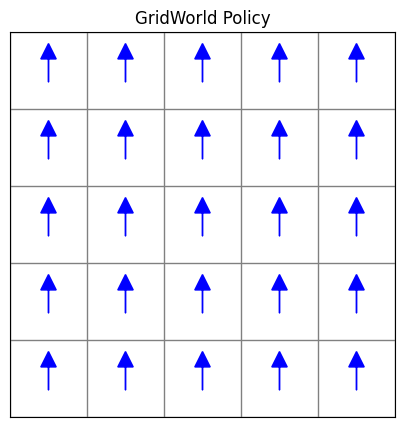

In [93]:
policy_directions = {state: env.get_action_space()[np.argmax(policy[state])] for state in env.get_state_space()}
display_policy(env,policy_directions)

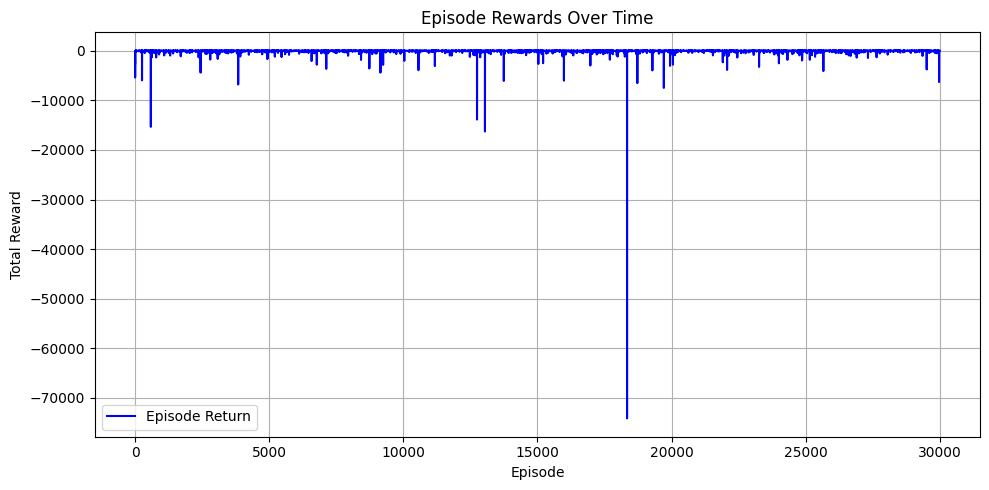

In [94]:
plot_rewards(total_rewards)

Agent returned to start position
Action:  Action.RIGHT Reward:  -0.01 Info:  Agent walk into empty cell
Action:  Action.DOWN Reward:  -0.01 Info:  Agent walk into empty cell
Action:  Action.RIGHT Reward:  -1 Info:  Agent fall into a trap!
Action:  Action.RIGHT Reward:  1 Info:  Agent find a treasures!
Action:  Action.RIGHT Reward:  0 Info:  Agent get to the goal!
#####################
Total reward  -0.020000000000000018
Number of steps:   5


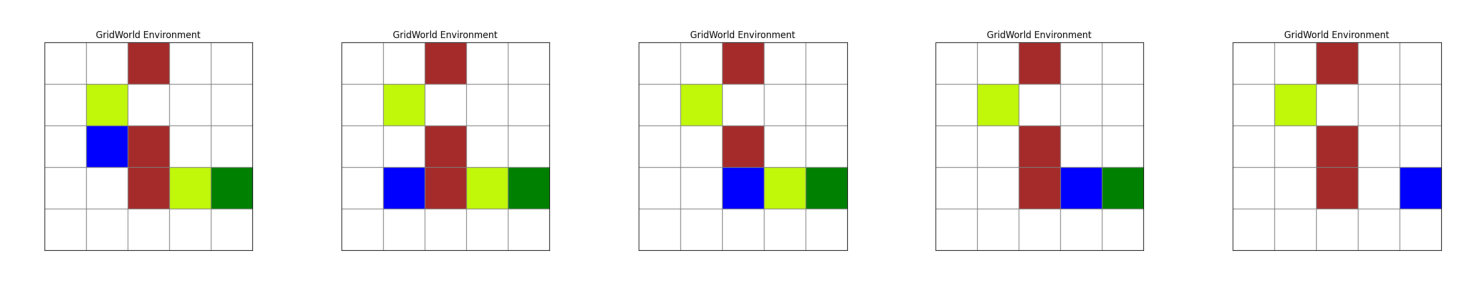

In [95]:
run_episode(env,MC)

## TD Learning
### SARSA (On policy)

In [96]:
class SARSA(RL_Model):
    def __init__(self, env, alpha=0.5, gamma=0.9, epsilon=0.1,n = 1):
        super().__init__(env, alpha, gamma, epsilon)
        self.n = n

    def select_action(self, state):
        
        return np.random.choice()
    
    def fit(self, num_episodes):
        episodes_rewards = []

        for episode in range(num_episodes):
            print('Runing episode ',episode+1,'/' , num_episodes)
            self.env.reset()
            state,action = self.exploring_starrt()
            done = False
            episode_reward = 0

            while(not done):
                action = self.select_action(state)
                next_state,reward,done,info = self.env.step(action)
                next_action = self.select_action(next_state)
                self.q[(state,action)] += (self.alpha *(reward + (self.gamma * self.q[next_state,next_action]) - self.q[(state,action)]))
                action = next_action
                state = next_state
                episode_reward += reward
            episodes_rewards.append(episode_reward)
        return self.q,self.policy,episodes_rewards
    

In [97]:
env.reset()
sarsa = SARSA(env,alpha=0.6,epsilon=0.1)
q_function,policy,total_rewards  = sarsa.fit(30000)

Runing episode  1 / 30000


TypeError: choice() takes at least 1 positional argument (0 given)

In [ ]:
policy_directions = {state: env.get_action_space()[np.argmax(policy[state])] for state in env.get_state_space()}
display_policy(env,policy_directions)

In [ ]:
plot_rewards(total_rewards)

In [ ]:
run_episode(env,sarsa)